In [165]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import random
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import pickle
import h5py
from tqdm import tqdm
import kagglehub

In [167]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [168]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [169]:
# define mask path
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_paths = [i.replace('_mask', '') for i in mask_paths]
print(f'{len(mask_paths)} {len(image_paths)}')

3929 3929


In [170]:
# set the seed for generating random numbers
torch.manual_seed(42)

In [171]:
# define mask path
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_paths = [i.replace('_mask', '') for i in mask_paths]
print(f'{len(mask_paths)} {len(image_paths)}')

3929 3929


In [172]:
# U-Net building blocks
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


In [173]:

class UNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        bottleneck = self.bottleneck(p4)
        return bottleneck, [c1, c2, c3, c4]

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, 2, 1)  # 2 classes: tumor, background

    def forward(self, bottleneck, skip_features):
        d4 = self.up4(bottleneck)
        d4 = torch.cat([d4, skip_features[3]], dim=1)
        d4 = self.conv4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, skip_features[2]], dim=1)
        d3 = self.conv3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, skip_features[1]], dim=1)
        d2 = self.conv2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, skip_features[0]], dim=1)
        d1 = self.conv1(d1)
        out = self.final(d1)
        return out

In [174]:
# U-Netmer model
class UNetmer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = UNetEncoder()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=1024, nhead=8, batch_first=True),
            num_layers=2
        )
        self.decoder = UNetDecoder()
        self.pos_embedding = nn.Parameter(torch.randn(196, 1024))  # 14x14=196 tokens for 224x224 input

    def forward(self, x):
        B, C, H, W = x.shape
        bottleneck, skip_features = self.encoder(x)
        tokens = bottleneck.view(B, 1024, -1).transpose(1, 2)  # (B, 196, 1024)
        tokens = tokens + self.pos_embedding
        transformed_tokens = self.transformer(tokens)
        bottleneck_transformed = transformed_tokens.transpose(1, 2).view(B, 1024, 14, 14)
        seg_map = self.decoder(bottleneck_transformed, skip_features)
        return seg_map


In [175]:
# Transforms
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})


In [176]:
# Generalized Dice Loss
def generalized_dice_loss(pred, target):
    pred = F.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=2).permute(0, 3, 1, 2).float()
    intersection = (pred * target_onehot).sum(dim=(2, 3))
    sum_pred = pred.sum(dim=(2, 3))
    sum_target = target_onehot.sum(dim=(2, 3))
    w = 1 / (sum_target ** 2 + 1e-6)
    dice = 2 * (w * intersection).sum(dim=1) / (w * (sum_pred + sum_target)).sum(dim=1)
    return 1 - dice.mean()


In [177]:

# Evaluation metrics
def compute_metrics(pred, target):
    pred = pred.argmax(dim=1).cpu().numpy()
    target = target.cpu().numpy()
    confusion = confusion_matrix(target.flatten(), pred.flatten(), labels=[0, 1])
    TP = confusion.diagonal()
    FP = confusion.sum(axis=0) - TP
    FN = confusion.sum(axis=1) - TP
    IoU = TP / (TP + FP + FN + 1e-6)
    Recall = TP / (TP + FN + 1e-6)
    Precision = TP / (TP + FP + 1e-6)
    F1 = 2 * Precision * Recall / (Precision + Recall + 1e-6)
    accuracy = TP.sum() / (confusion.sum() + 1e-6)
    macro_IoU = IoU.mean()
    return {
        'IoU': IoU,
        'Recall': Recall,
        'F1': F1,
        'accuracy': accuracy,
        'macro_IoU': macro_IoU,
        'confusion': confusion
    }


In [178]:
# Visualization for evaluation
def visualize_results(image, gt, pred, metrics, save_path='results.png'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes[0, 0].imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[0, 0].set_title('Input Image')
    axes[0, 1].imshow(gt.numpy(), cmap='gray')
    axes[0, 1].set_title('Ground Truth')
    axes[1, 0].imshow(pred.argmax(dim=0).numpy(), cmap='gray')
    axes[1, 0].set_title('Prediction')
    sns.heatmap(metrics['confusion'], annot=True, fmt='.0f', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Confusion Matrix')
    text = (f"Overall Acc: {metrics['accuracy']:.4f}\nMacro IoU: {metrics['macro_IoU']:.4f}\n"
            f"Tumor IoU: {metrics['IoU'][1]:.4f}, Recall: {metrics['Recall'][1]:.4f}, F1: {metrics['F1'][1]:.4f}")
    fig.text(0.5, 0.01, text, ha='center')
    plt.savefig(save_path)
   # plt.close()
    print(f"Evaluation visualization saved to {save_path}")



In [179]:
# Data verification visualization
def plot_from_img_path(n_examples, list_img_paths, list_mask_paths, save_path='data_check.png'):
    fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
    axs = axs if n_examples > 1 else [axs]
    for i, (ax_row, img_path, mask_path) in enumerate(zip(axs, list_img_paths[:n_examples], list_mask_paths[:n_examples])):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        ax_row[0].imshow(image)
        ax_row[0].set_title("MRI Image")
        ax_row[1].imshow(image)
        ax_row[1].imshow(mask, alpha=0.2)
        ax_row[1].set_title("Highlighted Abnormality")
        ax_row[2].imshow(mask, cmap='gray')
        ax_row[2].set_title("Abnormality Mask")
    plt.savefig(save_path)
    
    print(f"Data check visualization saved to {save_path}")


In [180]:
# DataFrame creation
def create_dataframe(base_dir='/kaggle/input/lgg-mri-segmentation/kaggle_3m'):
    mask_paths = glob.glob(os.path.join(base_dir, '*/*_mask*.tif'))
    image_paths = [p.replace('_mask', '') for p in mask_paths]
    df = pd.DataFrame(data={'image': image_paths, 'mask': mask_paths})
    df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
    df_test, df_val = train_test_split(df_test, test_size=0.3, random_state=42)
    df_train['split'] = 'train'
    df_val['split'] = 'val'
    df_test['split'] = 'test'
    df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)
    print(f"Created DataFrame: {len(df_train)} train, {len(df_val)} val, {len(df_test)} test")
    return df

In [181]:
# Data loading check
def check_data_loading(df, num_samples=3):
    if df.empty:
        print("DataFrame is empty.")
        return
    sample_df = df.sample(n=min(num_samples, len(df)), random_state=42)
    plot_from_img_path(num_samples, sample_df['image'].tolist(), sample_df['mask'].tolist())


In [182]:
# Dataset class
class BrainMRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image']
        mask_path = self.df.iloc[idx]['mask']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)  # Binary mask
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            # Ensure mask is torch.long for one_hot
            mask = mask.long()
            # Verify mask values are 0 or 1
            if mask.max() > 1 or mask.min() < 0:
                print(f"Warning: Mask at index {idx} has invalid values: min={mask.min()}, max={mask.max()}")
                mask = torch.clamp(mask, 0, 1)
        return image, mask

In [183]:
# DataLoader creation
def create_dataloaders(df, batch_size=4):
    train_df = df[df['split'] == 'train'].reset_index(drop=True)
    val_df = df[df['split'] == 'val'].reset_index(drop=True)
    test_df = df[df['split'] == 'test'].reset_index(drop=True)
    train_dataset = BrainMRIDataset(train_df, transform=train_transform)
    val_dataset = BrainMRIDataset(val_df, transform=val_transform)
    test_dataset = BrainMRIDataset(test_df, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    print(f"Created DataLoaders: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")
    return train_loader, val_loader, test_loader


In [184]:

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = generalized_dice_loss(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            # Compute training accuracy
            metrics = compute_metrics(outputs, labels)
            total_train_accuracy += metrics['accuracy']
            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {metrics["accuracy"]:.4f}')
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = generalized_dice_loss(outputs, labels)
                total_val_loss += loss.item()
                metrics = compute_metrics(outputs, labels)
                total_val_accuracy += metrics['accuracy']
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

In [185]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_metrics = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            metrics = compute_metrics(outputs, labels)
            all_metrics.append(metrics)
        # Aggregate metrics
        avg_metrics = {
            'IoU': np.mean([m['IoU'] for m in all_metrics], axis=0),
            'Recall': np.mean([m['Recall'] for m in all_metrics], axis=0),
            'F1': np.mean([m['F1'] for m in all_metrics], axis=0),
            'accuracy': np.mean([m['accuracy'] for m in all_metrics]),
            'macro_IoU': np.mean([m['macro_IoU'] for m in all_metrics]),
            'confusion': np.sum([m['confusion'] for m in all_metrics], axis=0)
        }
        print(f"Test Metrics: Overall Acc: {avg_metrics['accuracy']:.4f}, Macro IoU: {avg_metrics['macro_IoU']:.4f}, "
              f"Tumor IoU: {avg_metrics['IoU'][1]:.4f}, Recall: {avg_metrics['Recall'][1]:.4f}, F1: {avg_metrics['F1'][1]:.4f}")
        visualize_results(images[0].cpu(), labels[0].cpu(), outputs[0].cpu(), avg_metrics)


In [186]:
# Save model function
def save_model(model):
    torch.save(model.state_dict(), 'model.pth')
    with open('model.pkl', 'wb') as f:
        pickle.dump(model.state_dict(), f)
    with h5py.File('model.h5', 'w') as f:
        for k, v in model.state_dict().items():
            f.create_dataset(k, data=v.cpu().numpy())
    print("Model saved as model.pth, model.pkl, model.h5")


In [187]:
# Prediction visualization
def predict_and_visualize(model, test_loader, num_samples=3, save_path='predictions.png'):
    model.eval()
    samples = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            preds = model(images)
            samples.append((images.cpu(), labels.cpu(), preds.cpu()))
            if i + 1 >= num_samples:
                break
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*5))
    axes = axes if num_samples > 1 else [axes]
    for i, (image, gt, pred) in enumerate(samples):
        axes[i][0].imshow(image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[i][0].set_title('Input Image')
        axes[i][1].imshow(gt[0].numpy(), cmap='gray')
        axes[i][1].set_title('Ground Truth')
        axes[i][2].imshow(pred[0].argmax(dim=0).numpy(), cmap='gray')
        axes[i][2].set_title('Prediction')
    plt.tight_layout()
    plt.savefig(save_path)
    #plt.close()
    print(f"Prediction visualization saved to {save_path}")


Created DataFrame: 2750 train, 354 val, 825 test
Data check visualization saved to data_check.png
Created DataLoaders: 2750 train, 354 val, 825 test


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [1/688], Loss: 0.9984, Accuracy: 0.7131
Epoch [1/10], Step [11/688], Loss: 1.0000, Accuracy: 0.7691
Epoch [1/10], Step [21/688], Loss: 0.9927, Accuracy: 0.8882
Epoch [1/10], Step [31/688], Loss: 1.0000, Accuracy: 0.8481
Epoch [1/10], Step [41/688], Loss: 0.8658, Accuracy: 0.9236
Epoch [1/10], Step [51/688], Loss: 0.9308, Accuracy: 0.8428
Epoch [1/10], Step [61/688], Loss: 0.8112, Accuracy: 0.8093
Epoch [1/10], Step [71/688], Loss: 0.7857, Accuracy: 0.6866
Epoch [1/10], Step [81/688], Loss: 0.8349, Accuracy: 0.7366
Epoch [1/10], Step [91/688], Loss: 0.9726, Accuracy: 0.6649
Epoch [1/10], Step [101/688], Loss: 0.9130, Accuracy: 0.4077
Epoch [1/10], Step [111/688], Loss: 0.7743, Accuracy: 0.5168
Epoch [1/10], Step [121/688], Loss: 1.0000, Accuracy: 0.3447
Epoch [1/10], Step [131/688], Loss: 0.8446, Accuracy: 0.4918
Epoch [1/10], Step [141/688], Loss: 0.7039, Accuracy: 0.6636
Epoch [1/10], Step [151/688], Loss: 1.0000, Accuracy: 0.3247
Epoch [1/10], Step [161/688], Loss:

Training:  10%|█         | 1/10 [01:50<16:30, 110.09s/it]

Epoch [1/10] Train Loss: 0.8717, Train Accuracy: 0.6709, Val Loss: 0.8381, Val Accuracy: 0.8165
Epoch [2/10], Step [1/688], Loss: 0.7668, Accuracy: 0.8228
Epoch [2/10], Step [11/688], Loss: 0.7905, Accuracy: 0.8164
Epoch [2/10], Step [21/688], Loss: 0.9487, Accuracy: 0.8869
Epoch [2/10], Step [31/688], Loss: 1.0000, Accuracy: 0.7776
Epoch [2/10], Step [41/688], Loss: 0.7977, Accuracy: 0.8975
Epoch [2/10], Step [51/688], Loss: 0.8078, Accuracy: 0.8770
Epoch [2/10], Step [61/688], Loss: 0.7108, Accuracy: 0.9467
Epoch [2/10], Step [71/688], Loss: 0.9987, Accuracy: 0.7168
Epoch [2/10], Step [81/688], Loss: 0.5676, Accuracy: 0.8701
Epoch [2/10], Step [91/688], Loss: 0.8523, Accuracy: 0.9022
Epoch [2/10], Step [101/688], Loss: 0.8601, Accuracy: 0.9243
Epoch [2/10], Step [111/688], Loss: 0.5657, Accuracy: 0.9071
Epoch [2/10], Step [121/688], Loss: 0.7750, Accuracy: 0.9095
Epoch [2/10], Step [131/688], Loss: 0.6324, Accuracy: 0.7752
Epoch [2/10], Step [141/688], Loss: 0.5574, Accuracy: 0.7705


Training:  20%|██        | 2/10 [03:39<14:38, 109.79s/it]

Epoch [2/10] Train Loss: 0.8309, Train Accuracy: 0.8194, Val Loss: 0.8406, Val Accuracy: 0.9673
Epoch [3/10], Step [1/688], Loss: 1.0000, Accuracy: 0.8239
Epoch [3/10], Step [11/688], Loss: 1.0000, Accuracy: 0.8973
Epoch [3/10], Step [21/688], Loss: 0.5414, Accuracy: 0.8664
Epoch [3/10], Step [31/688], Loss: 0.7752, Accuracy: 0.8638
Epoch [3/10], Step [41/688], Loss: 1.0000, Accuracy: 0.8928
Epoch [3/10], Step [51/688], Loss: 1.0000, Accuracy: 0.7986
Epoch [3/10], Step [61/688], Loss: 0.7889, Accuracy: 0.9062
Epoch [3/10], Step [71/688], Loss: 0.8576, Accuracy: 0.9030
Epoch [3/10], Step [81/688], Loss: 0.5650, Accuracy: 0.9078
Epoch [3/10], Step [91/688], Loss: 0.9081, Accuracy: 0.9197
Epoch [3/10], Step [101/688], Loss: 0.9786, Accuracy: 0.8135
Epoch [3/10], Step [111/688], Loss: 0.8072, Accuracy: 0.9840
Epoch [3/10], Step [121/688], Loss: 1.0000, Accuracy: 0.8552
Epoch [3/10], Step [131/688], Loss: 1.0000, Accuracy: 0.8109
Epoch [3/10], Step [141/688], Loss: 0.6541, Accuracy: 0.8951


Training:  30%|███       | 3/10 [05:29<12:47, 109.63s/it]

Epoch [3/10] Train Loss: 0.8279, Train Accuracy: 0.8777, Val Loss: 0.8500, Val Accuracy: 0.8938
Epoch [4/10], Step [1/688], Loss: 0.9317, Accuracy: 0.9633
Epoch [4/10], Step [11/688], Loss: 1.0000, Accuracy: 0.9241
Epoch [4/10], Step [21/688], Loss: 0.7756, Accuracy: 0.8856
Epoch [4/10], Step [31/688], Loss: 1.0000, Accuracy: 0.8711
Epoch [4/10], Step [41/688], Loss: 0.6731, Accuracy: 0.9291
Epoch [4/10], Step [51/688], Loss: 0.8001, Accuracy: 0.7915
Epoch [4/10], Step [61/688], Loss: 0.7812, Accuracy: 0.7998
Epoch [4/10], Step [71/688], Loss: 0.7383, Accuracy: 0.7975
Epoch [4/10], Step [81/688], Loss: 0.7942, Accuracy: 0.8176
Epoch [4/10], Step [91/688], Loss: 0.5955, Accuracy: 0.8079
Epoch [4/10], Step [101/688], Loss: 0.8065, Accuracy: 0.8542
Epoch [4/10], Step [111/688], Loss: 0.5724, Accuracy: 0.8673
Epoch [4/10], Step [121/688], Loss: 0.6176, Accuracy: 0.8696
Epoch [4/10], Step [131/688], Loss: 0.7578, Accuracy: 0.9204
Epoch [4/10], Step [141/688], Loss: 1.0000, Accuracy: 0.9348


Training:  40%|████      | 4/10 [07:18<10:57, 109.67s/it]

Epoch [4/10] Train Loss: 0.8192, Train Accuracy: 0.8812, Val Loss: 0.8283, Val Accuracy: 0.8976
Epoch [5/10], Step [1/688], Loss: 1.0000, Accuracy: 0.8968
Epoch [5/10], Step [11/688], Loss: 0.8312, Accuracy: 0.8723
Epoch [5/10], Step [21/688], Loss: 0.7615, Accuracy: 0.8676
Epoch [5/10], Step [31/688], Loss: 0.8228, Accuracy: 0.8830
Epoch [5/10], Step [41/688], Loss: 0.8049, Accuracy: 0.9230
Epoch [5/10], Step [51/688], Loss: 0.7745, Accuracy: 0.9177
Epoch [5/10], Step [61/688], Loss: 1.0000, Accuracy: 0.9085
Epoch [5/10], Step [71/688], Loss: 0.7997, Accuracy: 0.9513
Epoch [5/10], Step [81/688], Loss: 0.7699, Accuracy: 0.9717
Epoch [5/10], Step [91/688], Loss: 0.7887, Accuracy: 0.9724
Epoch [5/10], Step [101/688], Loss: 0.8346, Accuracy: 0.9747
Epoch [5/10], Step [111/688], Loss: 0.8860, Accuracy: 0.9565
Epoch [5/10], Step [121/688], Loss: 1.0000, Accuracy: 0.9802
Epoch [5/10], Step [131/688], Loss: 0.6546, Accuracy: 0.9752
Epoch [5/10], Step [141/688], Loss: 0.6028, Accuracy: 0.9468


Training:  50%|█████     | 5/10 [09:08<09:08, 109.69s/it]

Epoch [5/10] Train Loss: 0.8036, Train Accuracy: 0.9438, Val Loss: 0.8090, Val Accuracy: 0.9814
Epoch [6/10], Step [1/688], Loss: 0.6518, Accuracy: 0.9696
Epoch [6/10], Step [11/688], Loss: 0.8422, Accuracy: 0.9800
Epoch [6/10], Step [21/688], Loss: 0.7446, Accuracy: 0.9729
Epoch [6/10], Step [31/688], Loss: 0.6084, Accuracy: 0.9793
Epoch [6/10], Step [41/688], Loss: 0.6013, Accuracy: 0.9893
Epoch [6/10], Step [51/688], Loss: 0.8576, Accuracy: 0.9541
Epoch [6/10], Step [61/688], Loss: 0.7552, Accuracy: 0.9751
Epoch [6/10], Step [71/688], Loss: 0.8200, Accuracy: 0.9549
Epoch [6/10], Step [81/688], Loss: 0.7830, Accuracy: 0.9846
Epoch [6/10], Step [91/688], Loss: 0.8265, Accuracy: 0.9825
Epoch [6/10], Step [101/688], Loss: 1.0000, Accuracy: 0.9822
Epoch [6/10], Step [111/688], Loss: 0.7311, Accuracy: 0.9929
Epoch [6/10], Step [121/688], Loss: 0.7834, Accuracy: 0.9682
Epoch [6/10], Step [131/688], Loss: 1.0000, Accuracy: 0.9620
Epoch [6/10], Step [141/688], Loss: 0.7695, Accuracy: 0.9842


Training:  60%|██████    | 6/10 [10:58<07:18, 109.69s/it]

Epoch [6/10] Train Loss: 0.7950, Train Accuracy: 0.9712, Val Loss: 0.7973, Val Accuracy: 0.9476
Epoch [7/10], Step [1/688], Loss: 1.0000, Accuracy: 0.9631
Epoch [7/10], Step [11/688], Loss: 1.0000, Accuracy: 0.9520
Epoch [7/10], Step [21/688], Loss: 0.7859, Accuracy: 0.9727
Epoch [7/10], Step [31/688], Loss: 0.8754, Accuracy: 0.9747
Epoch [7/10], Step [41/688], Loss: 0.7853, Accuracy: 0.9468
Epoch [7/10], Step [51/688], Loss: 0.7809, Accuracy: 0.9792
Epoch [7/10], Step [61/688], Loss: 0.2917, Accuracy: 0.9857
Epoch [7/10], Step [71/688], Loss: 0.6735, Accuracy: 0.9911
Epoch [7/10], Step [81/688], Loss: 0.5770, Accuracy: 0.9840
Epoch [7/10], Step [91/688], Loss: 0.7522, Accuracy: 0.9719
Epoch [7/10], Step [101/688], Loss: 0.6143, Accuracy: 0.9941
Epoch [7/10], Step [111/688], Loss: 0.5801, Accuracy: 0.9929
Epoch [7/10], Step [121/688], Loss: 0.6585, Accuracy: 0.9785
Epoch [7/10], Step [131/688], Loss: 1.0000, Accuracy: 0.9658
Epoch [7/10], Step [141/688], Loss: 0.7834, Accuracy: 0.9883


Training:  70%|███████   | 7/10 [12:47<05:28, 109.59s/it]

Epoch [7/10] Train Loss: 0.7952, Train Accuracy: 0.9740, Val Loss: 0.8337, Val Accuracy: 0.9858
Epoch [8/10], Step [1/688], Loss: 0.5632, Accuracy: 0.9798
Epoch [8/10], Step [11/688], Loss: 0.7339, Accuracy: 0.9772
Epoch [8/10], Step [21/688], Loss: 1.0000, Accuracy: 0.9810
Epoch [8/10], Step [31/688], Loss: 1.0000, Accuracy: 0.9778
Epoch [8/10], Step [41/688], Loss: 0.7422, Accuracy: 0.9951
Epoch [8/10], Step [51/688], Loss: 0.7831, Accuracy: 0.9963
Epoch [8/10], Step [61/688], Loss: 0.6760, Accuracy: 0.9885
Epoch [8/10], Step [71/688], Loss: 0.6193, Accuracy: 0.9896
Epoch [8/10], Step [81/688], Loss: 0.7880, Accuracy: 0.9913
Epoch [8/10], Step [91/688], Loss: 0.8777, Accuracy: 0.9747
Epoch [8/10], Step [101/688], Loss: 0.9055, Accuracy: 0.9868
Epoch [8/10], Step [111/688], Loss: 0.7973, Accuracy: 0.9892
Epoch [8/10], Step [121/688], Loss: 1.0000, Accuracy: 0.9874
Epoch [8/10], Step [131/688], Loss: 1.0000, Accuracy: 0.9898
Epoch [8/10], Step [141/688], Loss: 0.9852, Accuracy: 0.9756


Training:  80%|████████  | 8/10 [14:37<03:39, 109.54s/it]

Epoch [8/10] Train Loss: 0.8178, Train Accuracy: 0.9801, Val Loss: 0.8304, Val Accuracy: 0.9428
Epoch [9/10], Step [1/688], Loss: 0.8323, Accuracy: 0.9825
Epoch [9/10], Step [11/688], Loss: 0.9482, Accuracy: 0.9913
Epoch [9/10], Step [21/688], Loss: 0.9966, Accuracy: 0.9655
Epoch [9/10], Step [31/688], Loss: 0.7307, Accuracy: 0.9687
Epoch [9/10], Step [41/688], Loss: 0.7735, Accuracy: 0.9871
Epoch [9/10], Step [51/688], Loss: 0.7698, Accuracy: 0.9967
Epoch [9/10], Step [61/688], Loss: 0.7397, Accuracy: 0.9769
Epoch [9/10], Step [71/688], Loss: 0.9303, Accuracy: 0.9707
Epoch [9/10], Step [81/688], Loss: 0.7143, Accuracy: 0.9871
Epoch [9/10], Step [91/688], Loss: 0.8121, Accuracy: 0.9882
Epoch [9/10], Step [101/688], Loss: 0.8317, Accuracy: 0.9705
Epoch [9/10], Step [111/688], Loss: 0.8296, Accuracy: 0.9668
Epoch [9/10], Step [121/688], Loss: 0.7656, Accuracy: 0.9985
Epoch [9/10], Step [131/688], Loss: 0.9021, Accuracy: 0.9286
Epoch [9/10], Step [141/688], Loss: 0.8584, Accuracy: 0.9873


Training:  90%|█████████ | 9/10 [16:26<01:49, 109.54s/it]

Epoch [9/10] Train Loss: 0.8064, Train Accuracy: 0.9817, Val Loss: 0.8294, Val Accuracy: 0.9807
Epoch [10/10], Step [1/688], Loss: 0.6659, Accuracy: 0.9848
Epoch [10/10], Step [11/688], Loss: 0.8715, Accuracy: 0.9767
Epoch [10/10], Step [21/688], Loss: 1.0000, Accuracy: 0.9872
Epoch [10/10], Step [31/688], Loss: 0.8308, Accuracy: 0.9603
Epoch [10/10], Step [41/688], Loss: 0.6233, Accuracy: 0.9851
Epoch [10/10], Step [51/688], Loss: 0.9726, Accuracy: 0.9813
Epoch [10/10], Step [61/688], Loss: 0.7890, Accuracy: 0.9907
Epoch [10/10], Step [71/688], Loss: 0.8148, Accuracy: 0.9923
Epoch [10/10], Step [81/688], Loss: 1.0000, Accuracy: 0.9878
Epoch [10/10], Step [91/688], Loss: 0.9879, Accuracy: 0.9819
Epoch [10/10], Step [101/688], Loss: 0.8446, Accuracy: 0.9770
Epoch [10/10], Step [111/688], Loss: 0.6607, Accuracy: 0.9905
Epoch [10/10], Step [121/688], Loss: 0.9981, Accuracy: 0.9575
Epoch [10/10], Step [131/688], Loss: 0.9236, Accuracy: 0.9736
Epoch [10/10], Step [141/688], Loss: 0.8403, Ac

Training: 100%|██████████| 10/10 [18:15<00:00, 109.59s/it]

Epoch [10/10] Train Loss: 0.8069, Train Accuracy: 0.9828, Val Loss: 0.8237, Val Accuracy: 0.9855


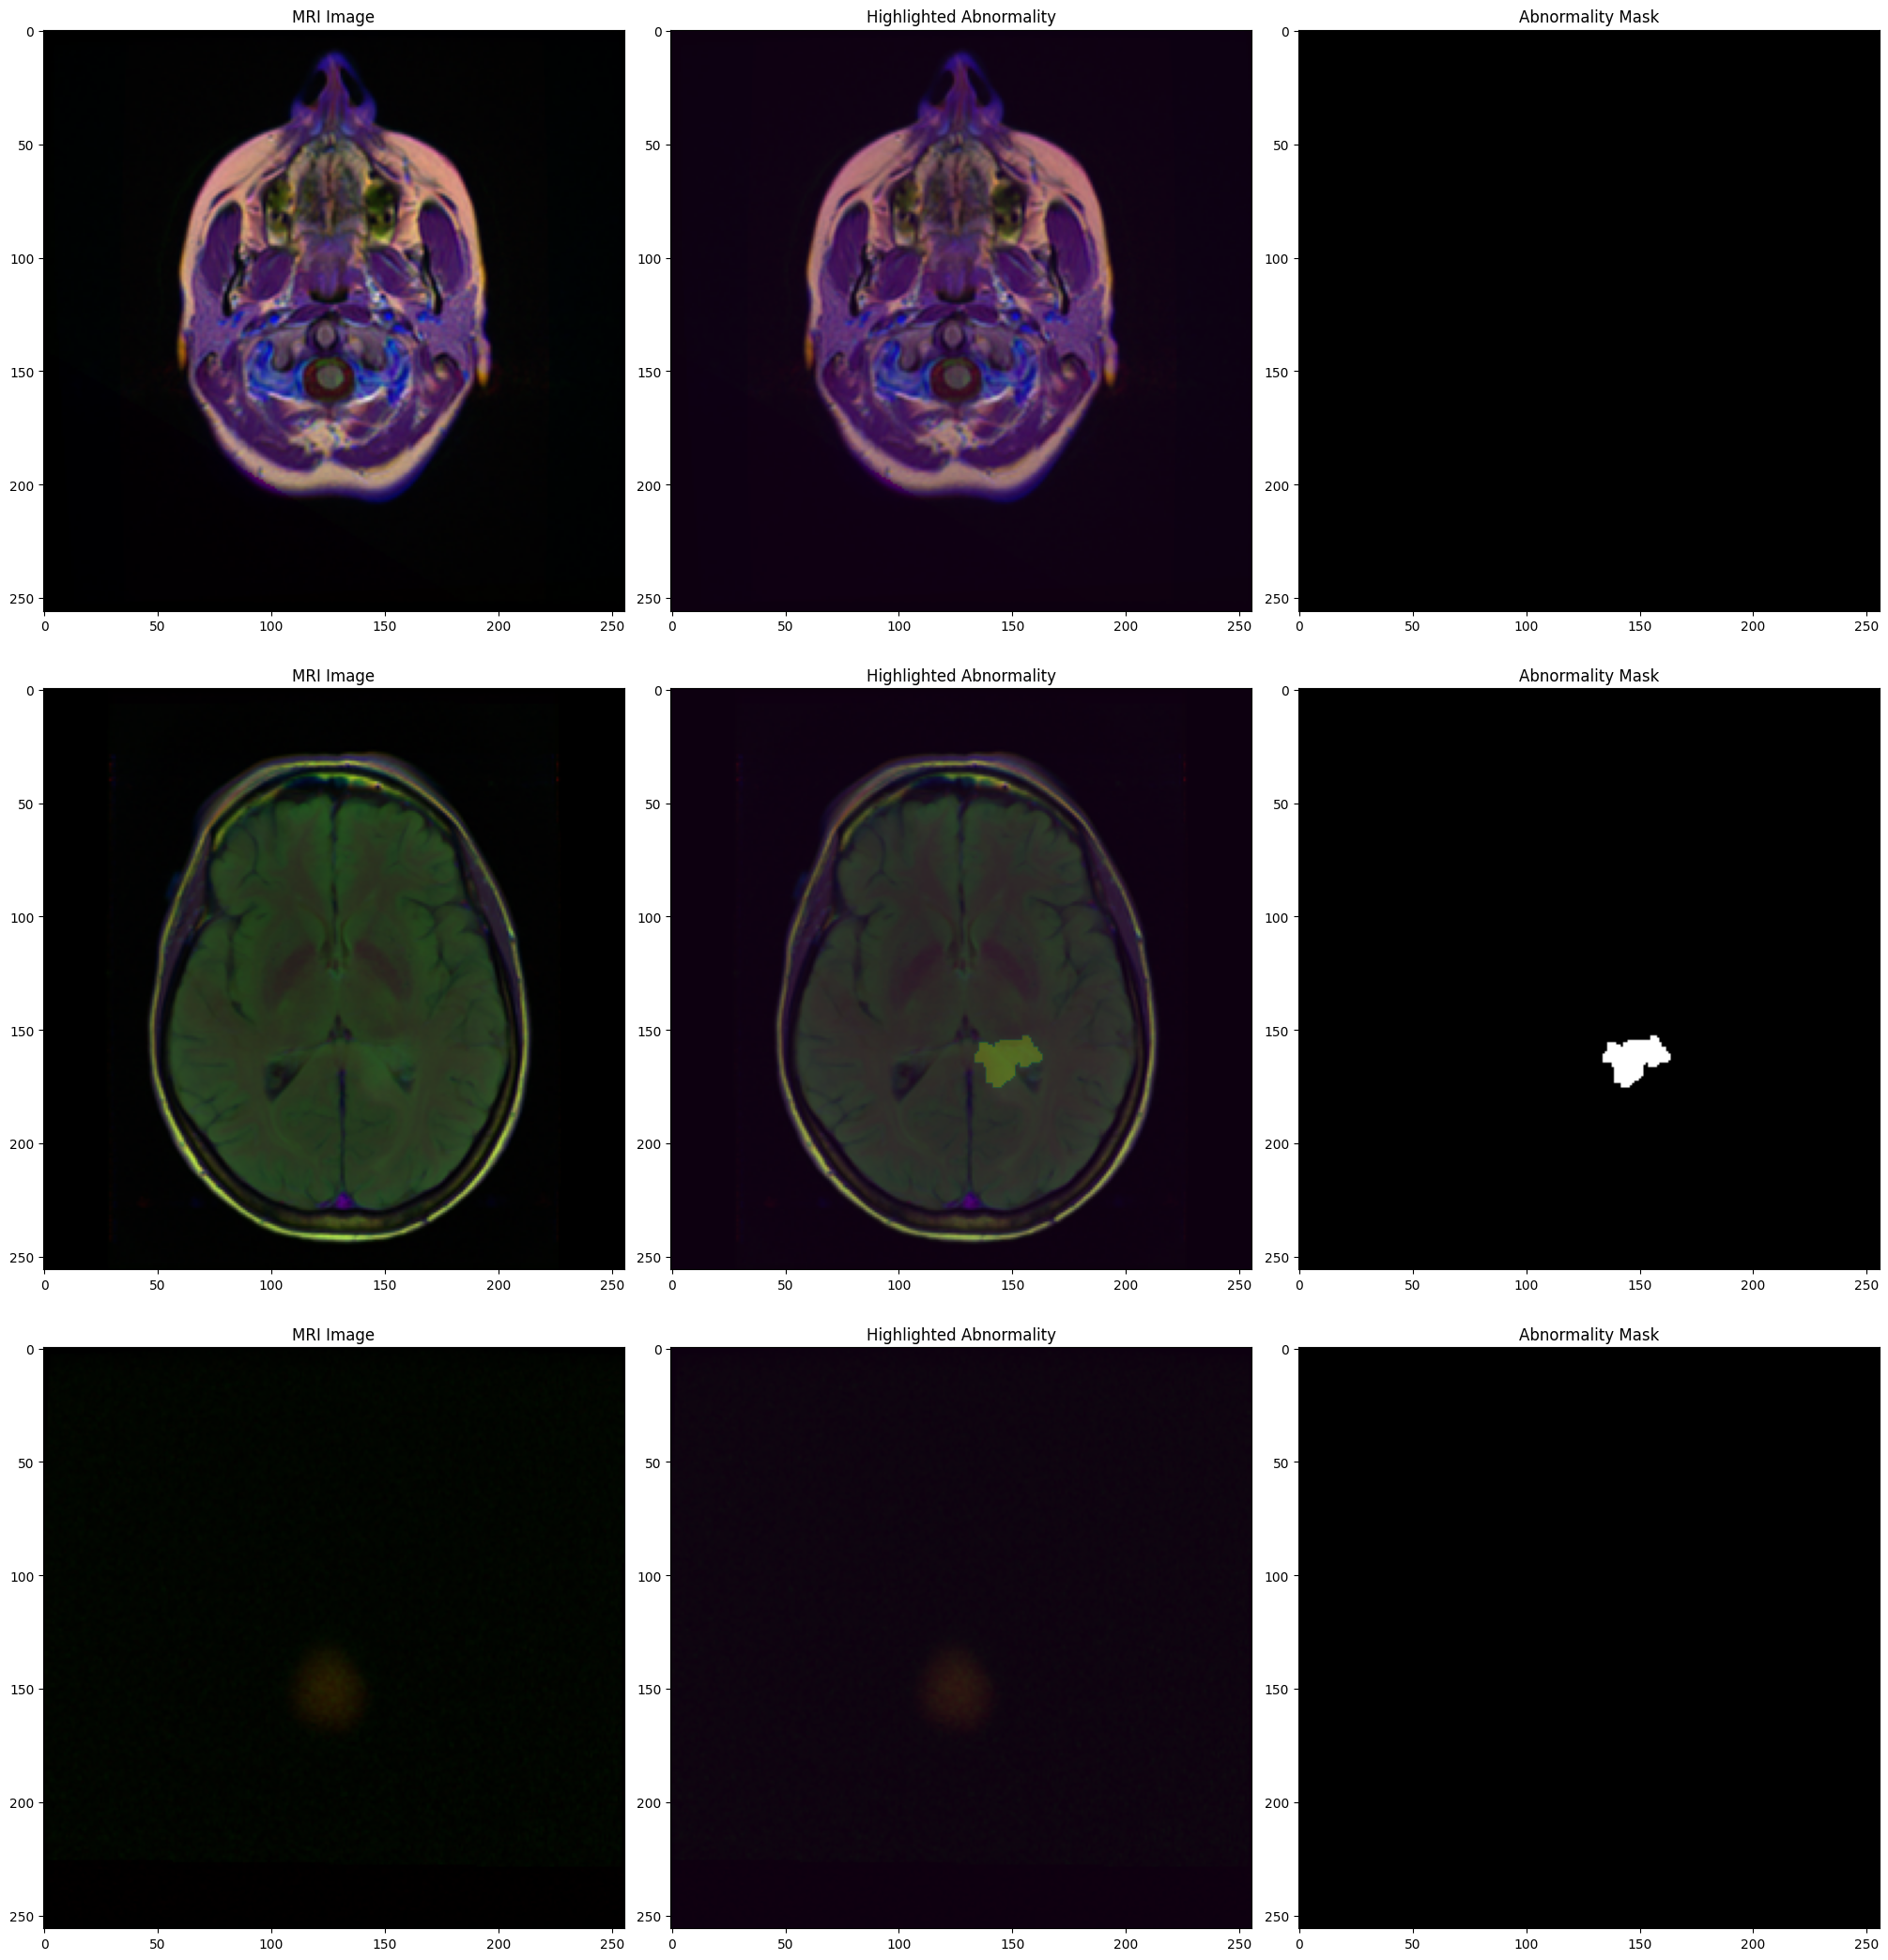

In [188]:
def main():
    df = create_dataframe()
    check_data_loading(df)
    train_loader, val_loader, test_loader = create_dataloaders(df)
    return train_loader, val_loader, test_loader

if __name__ == '__main__':
    # Setup data
    train_loader, val_loader, test_loader = main()
    # Initialize model
    model = UNetmer().to(device)
    # Run tasks separately as needed
    train_model(model, train_loader, val_loader)
    # evaluate_model(model, test_loader)
    # save_model(model)
    # predict_and_visualize(model, test_loader)

Evaluating: 100%|██████████| 825/825 [00:14<00:00, 56.19it/s]


Test Metrics: Overall Acc: 0.9859, Macro IoU: 0.5650, Tumor IoU: 0.1443, Recall: 0.1838, F1: 0.1769
Evaluation visualization saved to results.png


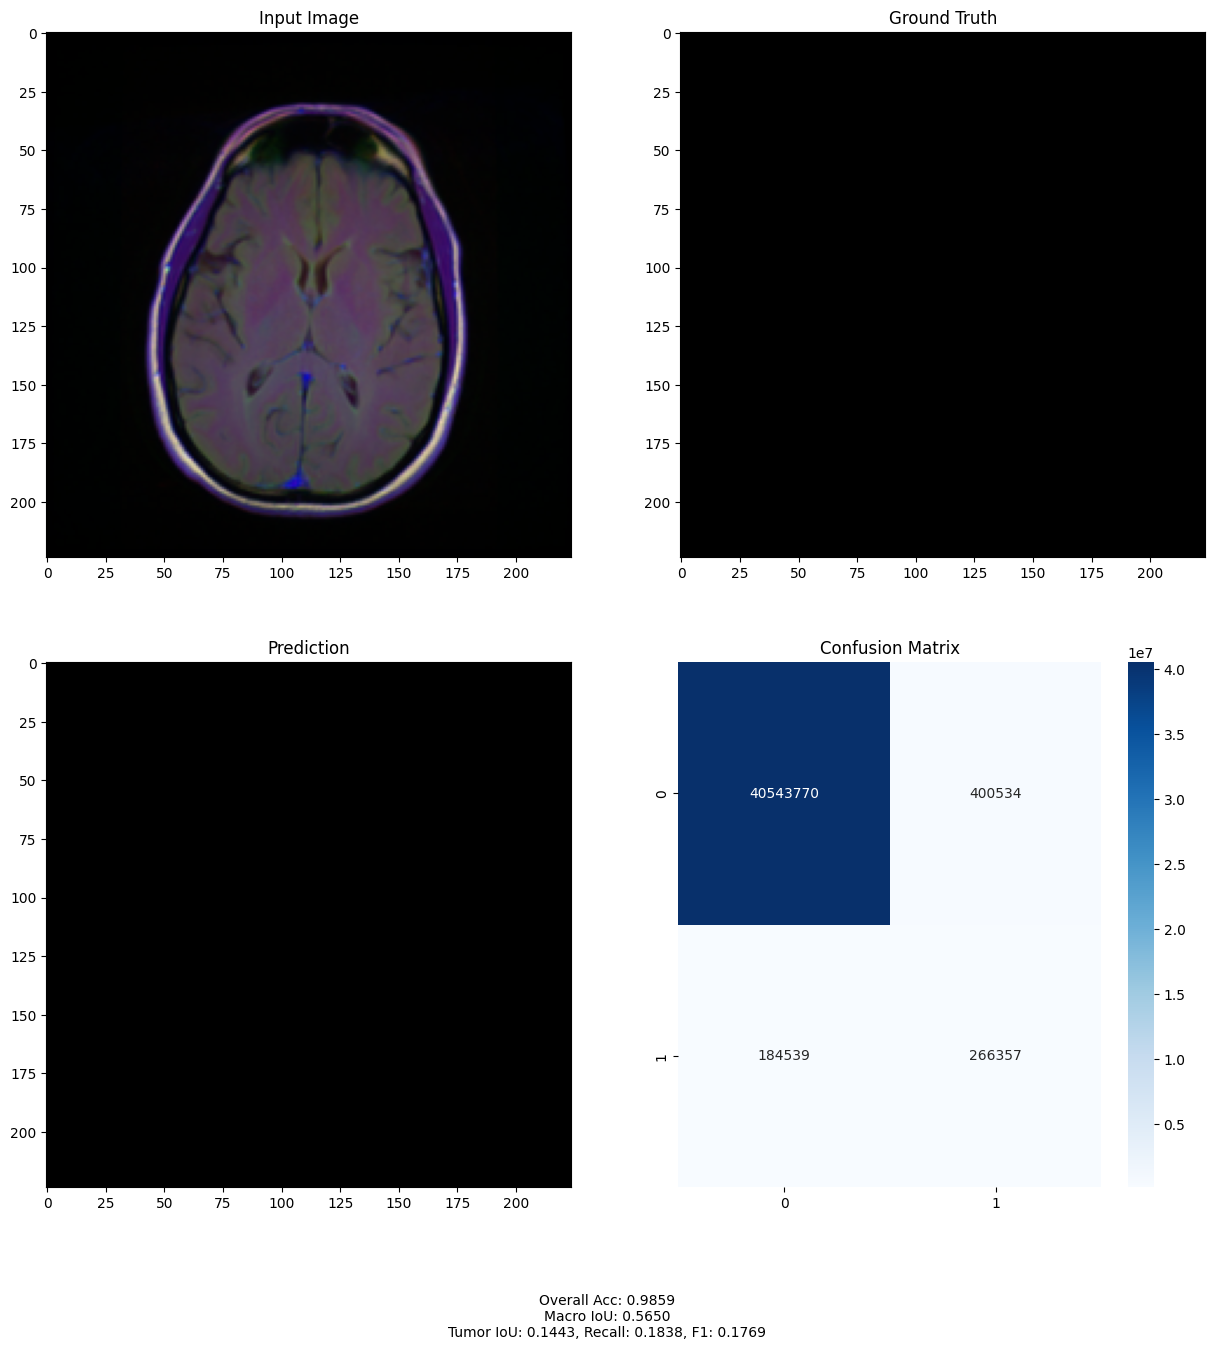

In [189]:
evaluate_model(model, test_loader)

In [190]:
save_model(model)

Model saved as model.pth, model.pkl, model.h5


Prediction visualization saved to predictions.png


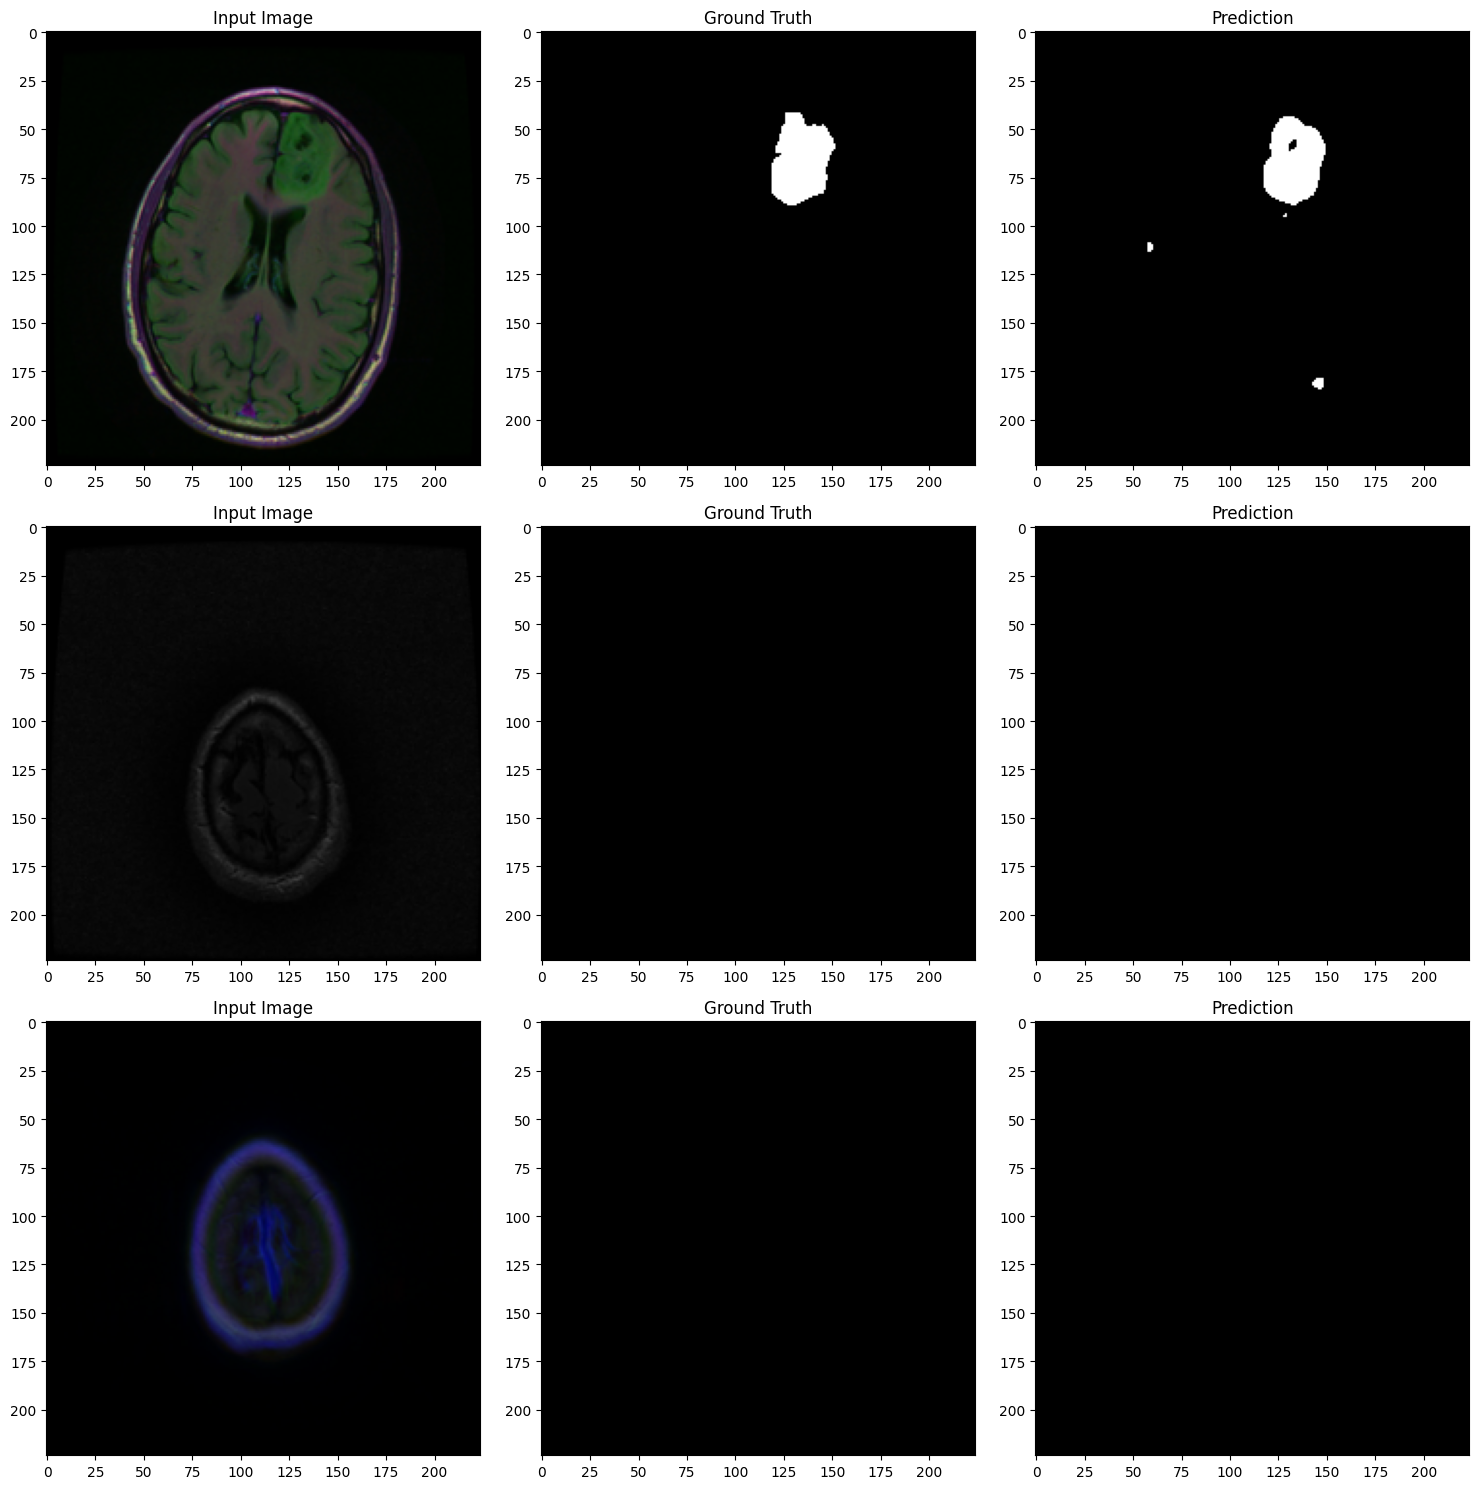

In [194]:
predict_and_visualize(model, test_loader)